In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from transformers import AutoTokenizer, AutoModelForMaskedLM

device = "cuda:0" if torch.cuda.is_available() else "cpu"


/home/kirill/miniconda3/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
from dataclasses import dataclass

@dataclass
class DialogueData:
    def _get_second_stage_emb(self, dial, data, embeddings, graph):
        start_idx = data.get_dialog_start_idx(dial)
        self.clusters = []
        self.second_stage_emb = []
        for i in range(len(dial.utterances)):
            lm_embedd = embeddings[start_idx + i, :].ravel()
            cluster = graph.one_stage_clustering.predict_cluster(lm_embedd, dial[i], dial).id
            self.second_stage_emb.append(graph.cluster_embeddings[cluster])
            self.clusters.append(cluster)

    def __init__(self, dial, data, embeddings, graph):
        utts = [str(utt) for utt in dial.utterances]
        r =  ".".join(utts) + "."
        self.str = r
        self.services = dial.meta['services']
        self._get_second_stage_emb(dial, data,embeddings, graph)

with open("dialogue_sim/data/mwtrain_sbert.pkl", "rb") as file:
    mwtrain = pickle.load(file)

with open("dialogue_sim/data/mwtest_sbert.pkl", "rb") as file:
    mwtest = pickle.load(file)

In [3]:
services = {s for d in mwtrain for s in d.services}
serv_to_idx = {s : i for i, s in enumerate(services)}

def serv_to_vec(services):
  ids = list(map(lambda x : serv_to_idx[x], services))
  vec = np.zeros(len(serv_to_idx))
  vec[ids] = 1
  return vec

class MultiWOZ(Dataset):
    def __init__(self, dials):
        self.dialogues = [dial.str for dial in dials]
        self.services = [serv_to_vec(dial.services) for dial in dials]

    def __len__(self):
        return len(self.dialogues)

    def __getitem__(self, idx):
        return (self.dialogues[idx],  self.services[idx])

train = MultiWOZ(mwtrain)
test = MultiWOZ(mwtest)

train_loader = DataLoader(train, batch_size = 16)
test_loader = DataLoader(test, batch_size = 16)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Shitao/RetroMAE_MSMARCO_finetune")

retromae = AutoModelForMaskedLM.from_pretrained("Shitao/RetroMAE_MSMARCO_finetune")
retromae.eval()
retromae.to(device);

Some weights of BertForMaskedLM were not initialized from the model checkpoint at Shitao/RetroMAE_MSMARCO_finetune and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import torch.nn as nn

class RetroMaeLinear(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = retromae.bert
    self.final_lin = nn.Linear(in_features = 768, out_features = 768)
  
  def forward(self, *args, **kwargs):
    enc = self.encoder(*args, **kwargs)
    cls = enc['last_hidden_state'][:, 0, :]
    return self.final_lin(cls)

model = RetroMaeLinear().to(device)
for param in model.encoder.parameters():
  param.requires_grad = False

In [6]:
def get_scores(emb):
  norm = torch.linalg.norm(emb, axis = 1)
  sim = emb @ emb.T 
  sim /= norm.reshape(-1, 1)
  sim /= norm.reshape(1, -1) 
  n = sim.shape[0]
  return sim[np.triu_indices(n, 1)]

def get_targets(data):
  n = data.shape[0]
  return (data @ data.T > 0).float()[np.triu_indices(n, 1)]

In [7]:
num_epochs = 2
optimizer = torch.optim.Adam(model.final_lin.parameters())
loss = nn.BCELoss()

def train_loop(model, tokenizer, optimizer, loss = None, num_epochs = 1):
    if loss is None:
        loss = nn.BCELoss()
    for epoch in range(num_epochs):
        for dials, serv in train_loader:
            inp = tokenizer(dials, return_tensors = "pt", padding = True, truncation = True).to(device)
            outp = model(**inp)
            del inp
            scores = get_scores(outp)
            del outp
            target = get_targets(serv)

            optimizer.zero_grad()
            l = loss((1 + scores) / (2.001), target.to(device))
            l.backward()
            optimizer.step()

            print(l)

In [9]:
train_loop(model, tokenizer, optimizer, loss, num_epochs = 3)

tensor(0.4448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [10]:
from tqdm.notebook import tqdm

def eval():
  with torch.no_grad():
    all_scores = np.array([])
    all_targets = np.array([])
    for dials, serv in tqdm(test_loader):
        inp = tokenizer(dials, return_tensors = "pt", padding = True, truncation = True).to(device)
        outp = model(**inp)
        del inp
        scores = get_scores(outp)
        del outp
        target = get_targets(serv)

        all_scores = np.concatenate((all_scores, scores.cpu().detach().numpy()))
        all_targets = np.concatenate((all_targets, target.cpu().detach().numpy()))
  return all_scores, all_targets

  0%|          | 0/63 [00:00<?, ?it/s]

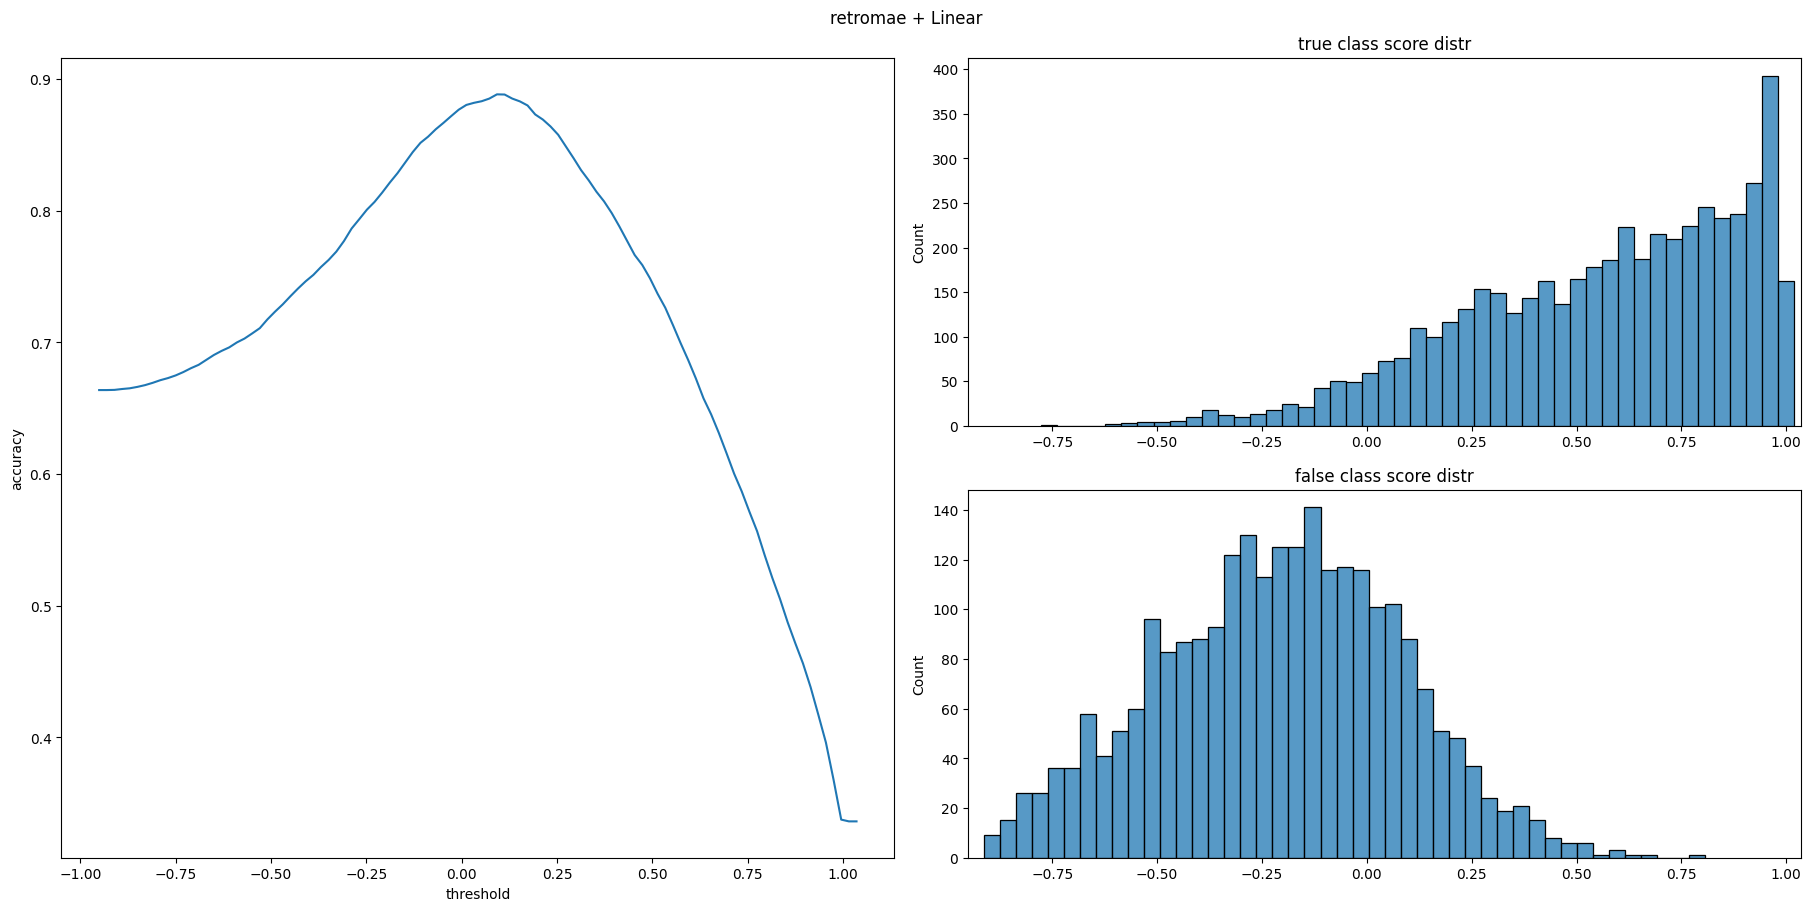

max acc: 0.888
class 1 prop : 0.6637653990358865


In [11]:
from dialogue_sim.utils import plot_pairwaise_class

scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "retromae + Linear")
res = {}
res['RetroMAE + Linear'] = max_acc

In [12]:
import torch.nn as nn

class FFN(nn.Module):
    def __init__(self, in_features = 768, hidden_neur = 1024, out_features = 256):
        super().__init__()
        self.l1 = nn.Linear(in_features = in_features, out_features = hidden_neur)
        self.act = nn.GELU()
        self.l2 = nn.Linear(in_features = hidden_neur, out_features = out_features)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        return self.l2(x)

class RetroMaeFFN(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = retromae.bert
    self.ffn = FFN()
  
  def forward(self, *args, **kwargs):
    enc = self.encoder(*args, **kwargs)
    cls_emb = enc['last_hidden_state'][:, 0, :]
    return self.ffn(cls_emb)

model = RetroMaeFFN().to(device)
for param in model.encoder.parameters():
  param.requires_grad = False

In [13]:
optimizer = torch.optim.Adam(model.ffn.parameters())
train_loop(model, tokenizer, optimizer, loss, num_epochs= 3)

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

  0%|          | 0/63 [00:00<?, ?it/s]

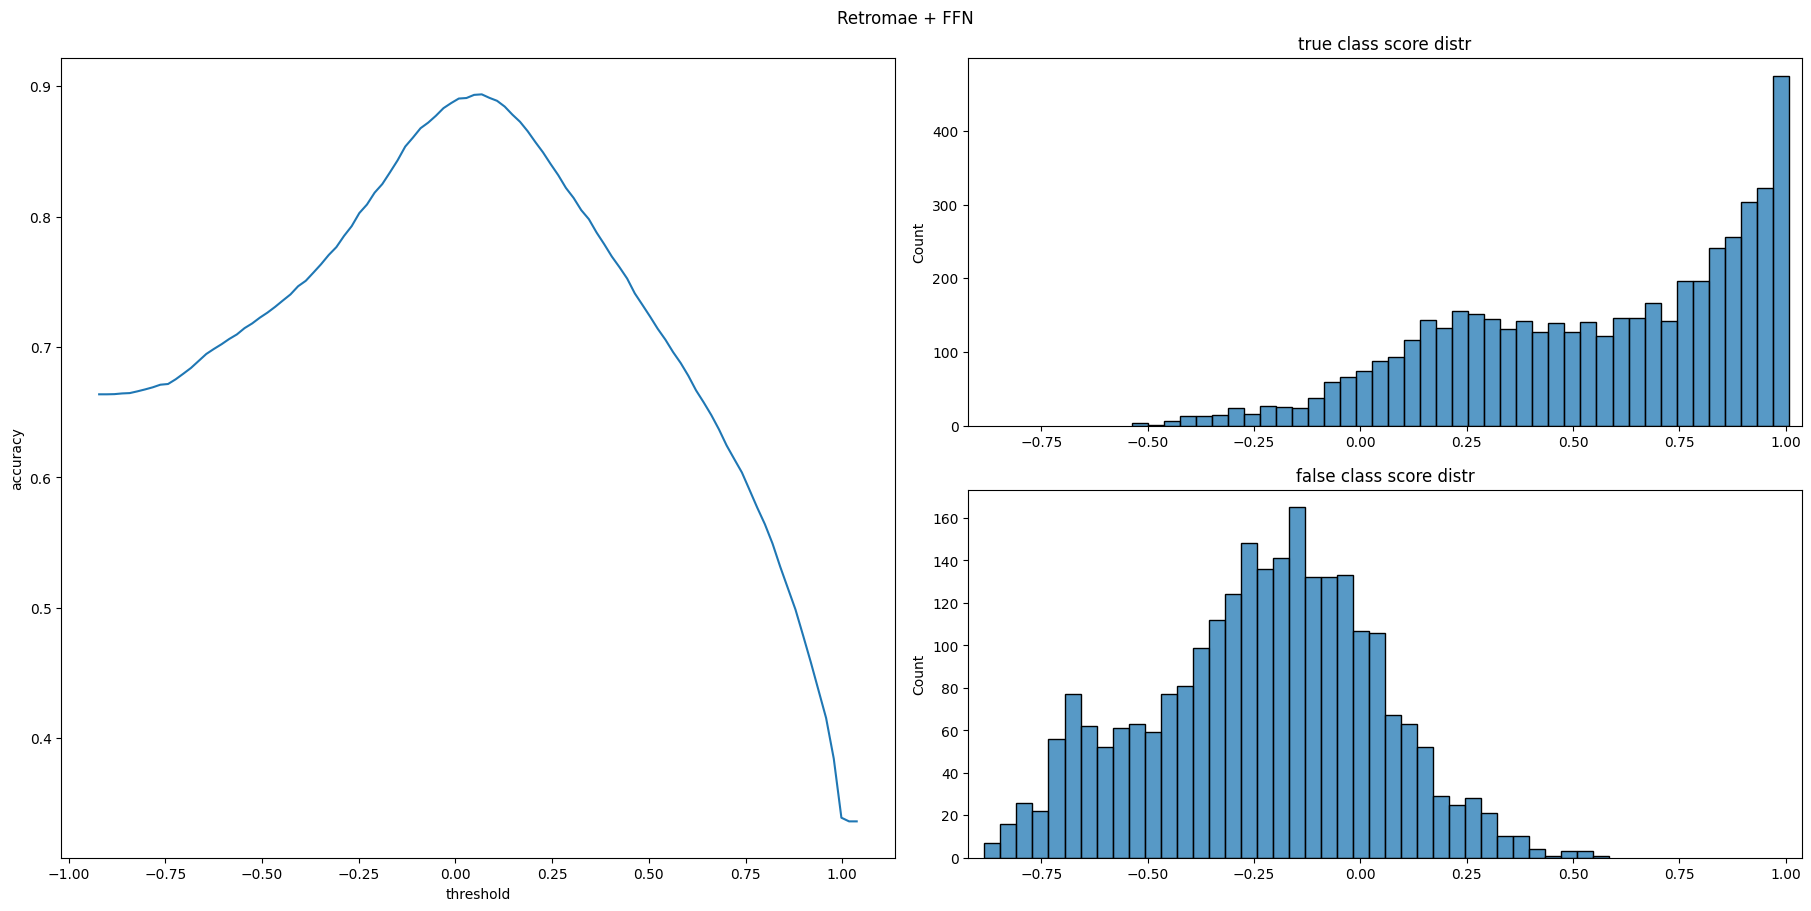

max acc: 0.894
class 1 prop : 0.6637653990358865


In [14]:
from dialogue_sim.utils import plot_pairwaise_class

scores, target = eval()
max_acc = plot_pairwaise_class(scores, target, "Retromae + FFN")
res['RetroMAE + FFN'] = max_acc

In [16]:
import pandas as pd

results = pd.DataFrame({'max acc' : res.values()})
results.index = res.keys()
results.sort_values('max acc', ascending = False)

,max acc
RetroMAE + FFN,0.893814
RetroMAE + Linear,0.888324
